<div class="alert alert-block alert-info">
<b>Note:</b> To run this notebook you will first need to generate a stratified design, using the <b>demo-stratified-design</b> notebook.
</div>

# Update Stratified Design Option 2: Exclude radius around specific sites
**In this notebook we show how a stratified design can be adapted, based on new information gained in the field. Sites which have already been sampled are left in place, while unsampled locations will be adjusted based on the new constraints imposed by the user.**

In this option we mask a radius around a specific site (or sites) which cannot be accessed. This information can be coded directly into the sample design csv, to avoid updating the mask manually (as in option 1).

### Import required libraries

In [3]:
import os
from osgeo import gdal, osr
import numpy as np
from random import randint
from scipy import ndimage
from copy import copy
import time
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

def get_file_info(file_path):
    '''
    Function which extracts a geotiff file as numpy array, and saves geographic projection information
    input: 
        file_path: (str) Path to the file
    output: 
        file_map: (np.array) The extracted map
        nbins: (int) The number of categories in the map
        res: (float) Resolution of the map in meters
        GeoT: The geographic transform used to project the map
        auth_code: The authority code matching the projection
    '''
    file_raw = gdal.Open(file_path)
    prj_info = file_raw.GetProjection()
    GeoT = file_raw.GetGeoTransform(); res = GeoT[1]
    file_map = file_raw.ReadAsArray()
    nbins = len(np.unique(file_map))
    return file_map, nbins, res, GeoT, prj_info

# User Inputs

<div class="alert alert-block alert-info">
<b>Note:</b> Sections where users can enter their own values are highlighted with #'s. 
    
<b>Example files currently entered link to datasets in the raw data folder, which can be used for testing. </b>
</div>

Specify a unique name for the project as ```save_folder```. A folder with your chosen name will be created in the ```results``` directory, and all outputs for the design will be saved there. E.g:

In [4]:
############################################
save_folder = 'Adapted_Stratified_Demo_Opt2'
############################################

In [5]:
directory = 'results/{}'.format(save_folder)
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Create unique time stamp to add to file names (to avoid overwriting)
ts = time.gmtime()
ts = time.strftime("%Y_%m_%d_%H%M%S", ts)

print('Results will be saved in the folder {}'.format(directory))
print('Files will start with the time stamp {}'.format(ts))

Results will be saved in the folder results/Adapted_Stratified_Demo_Opt2
Files will start with the time stamp 2019_10_30_140158


Enter path to **original** invalid areas mask (`mask_path`) used to generate the stratified design . This should be in GeoTiff format and saved in the 'raw' data folder. E.g:

In [6]:
######################################
mask_path = 'raw/InvalidAreasMask.tif'
######################################

Load the .csv file output by the original stratified design. In the "sampled" column, **unsampled** sites should be labelled with a **zero**. Sites which have been **visited** and are known to be accessible should be tagged with a **one**. The site which requires masking shoud be labelled with a **two**. 

In [7]:
###############################################################################################
csv_path = 'results/Stratified_Design_Demo/2019_02_25_121053_30Site_Stratified_tagged_opt2.csv'
###############################################################################################

Enter the radius (in meters) which you would like to exclude around your selected sites (tagged with 2's). E.g:

In [8]:
#############
radius = 3000
#############

## Load data

To project the final sites into longitude and latitude, we extract geographic information from the invalid areas mask.

In [15]:
print('Loading {} ...'.format(mask_path))

mask, nbins, res, GeoT, prj_info = get_file_info(mask_path)

print('\nNumber of categories in mask (should only be two): {}'.format(nbins))
print('Pixel resolution (m): {}'.format(res))
print('GeoT info: {}'.format(GeoT))

Loading raw/InvalidAreasMask.tif ...

Number of categories in mask (should only be two): 2
Pixel resolution (m): 30.0
GeoT info: (604343.5084861958, 30.0, 0.0, 5302852.190465175, 0.0, -30.0)


Load the tagged csv file

In [16]:
sampled_csv = pd.read_csv(csv_path)

**Update the mask based on information in the csv**

In [17]:
def update_mask(site_df, mask, radius, res):
    
    # Create array same dimensions as input mask
    imheight, imwidth = mask.shape
    mask_update = np.ones((imheight, imwidth))
    
    # Set the point to mask as a zero
    center_pixel = site_df.loc[site_df['sampled']==2]
    x = center_pixel['row'].values; y = center_pixel['col'].values
    mask_update[x, y] = 0
    
    # Threshold distance transform and add to original mask
    dist_im = ndimage.distance_transform_edt(mask_update)*res
    dist_im[dist_im<radius] = 0; dist_im[dist_im>=radius] = 1  
    
    new_mask = dist_im * mask
    
    return new_mask

In [18]:
updated_mask = update_mask(sampled_csv, mask, radius, res)

**Plot updated mask**

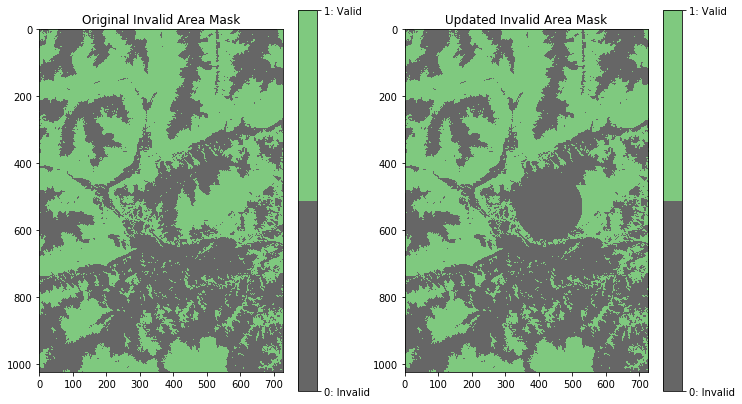

In [19]:
plt.figure(figsize=(12, 7))

plt.subplot(121)
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('Original Invalid Area Mask')
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])

plt.subplot(122)
plt.imshow(updated_mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('Updated Invalid Area Mask')
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.show()

## Generate updated stratified design

Now we have our inputs, we are ready to generate the design. 

This function keeps the sites which have already been sampled fixed, and then adjusts the location of all unsampled sites based on the new mask constraints.

In [21]:
def update_stratified_design(mask, sampled_csv):
    
    nsp = len(sampled_csv) 
    sampled_df = sampled_csv.loc[sampled_csv['sampled']==1]
    nsampled = len(sampled_df)
    print('{} sites already sampled and will not be moved'.format(nsampled))
    print('{} sites to be adjusted based on mask update'.format(nsp-nsampled))
    
    imheight, imwidth = mask.shape
    sampled_x = sampled_df['row'].values
    sampled_y = sampled_df['col'].values

    sites = np.ones((imheight, imwidth))
    sites[sampled_x, sampled_y] = 0
    mask_aux = copy(mask)
    x_vals = [sampled_x]
    y_vals = [sampled_y]

    for i in range(nsp - nsampled):
        
        print('Plotting site {} of {}'.format(i+1, nsp-nsampled))

        # Generate EDT image of all sampled/selected sites
        dist_im = ndimage.distance_transform_edt(sites) * mask
        
        # Extract coordinates with the maximum distance value
        dist_mx = list(zip(*np.where(dist_im == dist_im.max())))
        
        # Choose one maximum coord pair at random
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]

        # Make all elements of EDT map in invalid region 0
        dist_im = dist_im * mask_aux
        
        # Extract coords of pixels with maximum distance value
        dist_mx = list(zip(*np.where(dist_im == dist_im.max())))

        # Choose one max coord pair at random
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]

        # Save x and y coords
        x_vals = np.append(x_vals, x)
        y_vals = np.append(y_vals, y)

        # Code chosen site to be zero (a feature pixel) in site array
        sites[x, y] = 0
        
    print('Adapted stratified design complete!')

    return x_vals, y_vals


In [22]:
x_adpt, y_adpt = update_stratified_design(updated_mask, sampled_csv)

9 sites already sampled and will not be moved
21 sites to be adjusted based on mask update
Plotting site 1 of 21
Plotting site 2 of 21
Plotting site 3 of 21
Plotting site 4 of 21
Plotting site 5 of 21
Plotting site 6 of 21
Plotting site 7 of 21
Plotting site 8 of 21
Plotting site 9 of 21
Plotting site 10 of 21
Plotting site 11 of 21
Plotting site 12 of 21
Plotting site 13 of 21
Plotting site 14 of 21
Plotting site 15 of 21
Plotting site 16 of 21
Plotting site 17 of 21
Plotting site 18 of 21
Plotting site 19 of 21
Plotting site 20 of 21
Plotting site 21 of 21
Adapted stratified design complete!


# Results

**Plot Design**

We can now check how our design looks over the landscape.

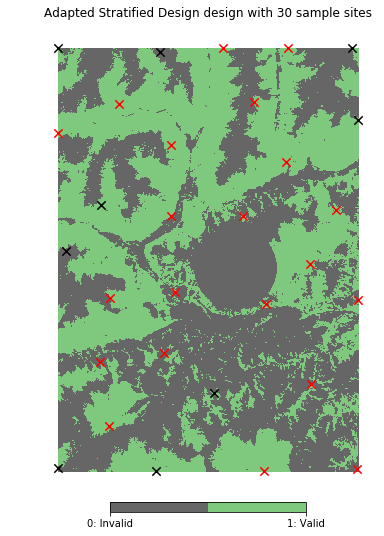

In [28]:
plt.figure(figsize=(7, 9))
plt.imshow(updated_mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('{} design with {} sample sites'.format('Adapted Stratified Design', len(x_adpt)))
plt.axis('off')
cbar = plt.colorbar(fraction=0.02, orientation='horizontal', pad=0.01)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
nsampled = sum(sampled_csv.sampled==1)
nsp = len(sampled_csv)
plt.scatter(y_adpt[:nsampled], x_adpt[:nsampled], c='black', marker='x', linewidth=1.5, s=70)
plt.scatter(y_adpt[nsampled:], x_adpt[nsampled:], c='red', marker='x', linewidth=1.5, s=70)
plt.savefig('{}/{}_{}Site_Adapted_Stratified_Plot.tif'.format(directory, ts, nsp))
plt.show()

Black crosses represent sites which have already been visited, while red show the sites which have been moved based on the new mask constraints.

### Save the design

In [29]:
def LongLatConvert(x, y, projection_info, GeoT):
    
    # Project row and column (will be for bottom left corner)
    x_proj = x * GeoT[1] + GeoT[0] 
    y_proj = y * GeoT[5] + GeoT[3]
    
    # Shift from bottom left to centre of the pixel
    x_proj += GeoT[1] / 2.0
    y_proj += GeoT[5] / 2.0 
    
    xy_proj = np.stack((x_proj, y_proj), axis=-1)
    
    # Make spatial coordinate system
    srs = osr.SpatialReference()
    if srs.ImportFromWkt(projection_info) != 0:
        print("Error: cannot import projection '%s'" % projection_info)
        sys.exit(1)
        
    srsLatLong = srs.CloneGeogCS()
    ct = osr.CoordinateTransformation(srs, srsLatLong)
    long, lat, height = list(zip(*ct.TransformPoints(xy_proj)))
    return long, lat

In [30]:
# Convert from row/col to projected
long, lat = LongLatConvert(x_adpt, y_adpt, prj_info, GeoT)

Now save the results to a csv file...

In [31]:
# Record the sites which have already been sampled
nsp = len(sampled_csv)
nsampled = sum(sampled_csv.sampled==1)

# Reformat and save to csv
result = pd.DataFrame()
result['longitude'] = long; result['latitude'] = lat
result['row'] = x_adpt; result['col'] = y_adpt
result['sampled'] = [1]*nsampled + [0]*(nsp-nsampled)
result.index += 1
csv_filename = '{}_{}Site_Adapted_Stratified.csv'.format(ts, nsp)
result.to_csv('{}/{}'.format(directory, csv_filename), index_label='site')

print('Design results saved as a csv in {} directory \nFile name: {}'.format(directory, csv_filename))

Design results saved as a csv in results/Adapted_Stratified_Demo_Opt2 directory 
File name: 2019_10_30_140158_30Site_Adapted_Stratified.csv


### Example output:

You should now be able to navigate to the results folder (specified above) and open the csv using your preferred software. We can load and print the csv here as a quick check. 

In [32]:
view_csv = pd.read_csv('{}/{}'.format(directory, csv_filename))

In [33]:
view_csv

,site,longitude,latitude,row,col,sampled
0,1,172.575026,-42.517812,834,377,1
1,2,172.268461,-42.419761,0,0,1
2,3,172.336065,-42.615136,174,726,1
3,4,172.447568,-42.422772,491,19,1
4,5,172.638446,-42.415069,1015,0,1
5,6,172.273458,-42.486438,10,247,1
6,7,172.643392,-42.478758,1024,236,1
7,8,172.272357,-42.612079,0,712,1
8,9,172.407246,-42.445969,379,103,1
9,10,172.494765,-42.613175,608,726,0


Columns consist of:
* A **site** ID
* The coordinates in **longitude** and **latitude**
* The coordinates in **row** and **column** (corresponding to pixels in image)
* A **sampled** column: There should be ones in the sites which have already been sampled, and zeros in all the sites which have been adjusted based on the new constraints. 